# Sequential Bayesian Learning (SBL)
## Authors:  Author: Robert Tjarko Lange, Miro Grundei, Sam Gjisem
## Last Update: December 2018

# 0. General Introduction to the project

In this project we investigate the theoretical modelling of mismatch-negativity in the human somatosensory cortex. More specifically, we study a novel roving paradigm which is generated from a structured graphical model. This allows us to define standard and deviant stimuli in stimulus-feature-independent manner. Furthermore, sampling (as opposed to deterministic sequence generation) enables us to control for sequence-dependent cofounding factors.

The following notebook is structured as follows:

- **1. Generation of Trial Sequences based on Graphical Model**
    * We formulate a general Markov model which generates a sequence of trials (0 - low intensity, 0.5 - catch trial, 1 - high intensity)
    * The alternation probability between different observations depends upon the previous observed states as well as the hidden state/regime which is modeled as a Markov Chain.
    * We are able to increase the order of the Markov dependency in the data-generating process. This allows to vary the complexity of the sequence generation.
    
    
- **2. Modeling of different Sequential Bayesian Learning Agents**.
    * The agents process the trial sequence as it comes in. Based on different probabilistic models they update there current posterior estimate about the hidden state that drives the sampling of the observed state. 
    * Based on her current posterior estimate, we can calculate different surprise measures (e.g. Predictive, Bayesian as well as Confidence-Corrected). These surprise measures indicate how well the agent is able to infer the data-generating mechanism and the corresponding hidden states.
    * Going forward we will combine the data-generating paradigm and surprise measures with frequency data obtained from an EEG study. Thereby, we will be able to compare different models with different degrees of complexity of somatosensory adaptation and learning.
    
    
- **3. Model Comparison across Different SBL Agents and Surprise Regressors**
    * Evaluation of theoretical models in explaining the EEG frequency variation.

In [ ]:
!pip install -r requirements.txt --quiet

In [1]:
# Import relevant sampling modules
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [2]:
import os
import time
import numpy as np

import pymc3 as pm
import theano
import matplotlib.pyplot as plt

from utils.helpers import *
from utils.plotting import *
from utils.glm_models import *

import sampling.seq_gen as sg
import sampling.seq_analysis as sa

# Import relevant SBL modules
import sbl_agents.sbl_cat_dir as sbl_cd
import sbl_agents.sbl_hmm as sbl_hmm

# Set random seed for replicability and define directories
np.random.seed(seed=1234)
results_dir = os.getcwd() + "/results/"
fig_dir = os.getcwd() + "/figures/"
data_dir = os.getcwd() + "/data/"

# 1. Generation of Trial Sequence based on Graphical Model

Our sampling paradigm is motivated by the classical roving paradigm. In such a setting a deviant is defined relative to the previous trials.

Depending on whether or not we account for second order Markov dependency also $o_{t-2}$ influences the sampling probabilities. Our generating process can be described by the following graphical model:

<img src="figures/gm_seq_gen.png" alt="drawing" width="750"/>

* Catch: $p(o_t = 0.5) = 0.05$
* Regime switch: $p(s_t \neq s_{t-1}) = 0.01$

Sample a sequence from the Graphical Model and saves it to .mat file
* 1st order Markov sequence of length 800 with following probabilities:
    * Regime 0: $p(o_t = 0|o_{t-1}=0, s_t=0), p(o_t = 1|o_{t-1}=0, s_t=0)$
    * Regime 1: $p(o_t = 0|o_{t-1}=0, s_t=1), p(o_t = 1|o_{t-1}=0, s_t=1)$
```
pythonw seq_gen.py -t 1st_temp -reg_init 0.5 -reg_change 0.01 -catch 0.05 -obs_init 0.5 -obs_change 0.35 0.65 0.65 0.35 -order 1 -v -seq
800
```

* 2nd order Markov sequence of length 800 with following probabilities:
    * Regime 0: $p(o_t = 0|o_{t-1}=0, o_{t-1}=0) = 0.35, p(o_t|o_{t-1}) = 0.65$
    * Regime 1: $p(o_t = 0|o_{t-1}=0) = 0.65, p(o_t|o_{t-1}) = 0.35$
```
pythonw seq_gen.py -t 1st_temp -reg_init 0.5 -reg_change 0.01 -catch 0.05 -obs_init 0.5 -obs_change 0.35 0.65 0.65 0.35 -order 2 -v -seq
800
```

In [3]:
# Define parameters for sequence sampling
prob_regime_init = np.array([0.5, 0.5])  # Prob. vector for inital regime (hidden state)
prob_regime_change = 0.01  # Prob. of sampling a regime change
prob_obs_init = np.array([0.5, 0.5, 0])  # Prob. vector for inital trial/stimulus (observed state)
prob_obs_change = [0.45, 0.45, 0.05, 0.05, 0.05, 0.05, 0.45, 0.45]  # Prob. matrix for different regimes
prob_catch = 0.05  # Prob. of sampling a catch trial (independent of hidden state)

order = len(prob_obs_change)/4  # Markov order/lag dependency in the sampling scheme
seq_length = 200  # Length of sampled sequence
sample_file = "S1_200"  # Title of file saved
matlab_out = True  # Boolean - store file as .mat - otherwise .pkl file
plot_seq = True  # Booelean - plot the sampled sequence
verbose = True  # Print out the transition prob. specification and empirical statistics of the sampled seq
plot_seqs = True

In [4]:
# Create instance of sampling class
gen_temp = sg.seq_gen(order, prob_catch, prob_regime_init, prob_regime_change,
                      prob_obs_init, prob_obs_change, verbose)

All input arrays conform with the specified dimensions.
HHMM correctly initialized. Ready to Sample.
--------------------------------------------
2nd Order Transition Prob. 
 Regime 0: p(0|00)=0.45, p(0|01)=0.45, p(0|10)=0.05,  p(0|11)=0.05 
 Regime 1: p(0|00)=0.05, p(0|01)=0.05, p(0|10)=0.45,  p(0|11)=0.45
--------------------------------------------


Empirical Probabilities: 
 Empirical Catch Prob.: 0.05 
 Empirical Regime Switch Prob.: 0.03 
 Empirical Overall High-Intensity Stimulus Prob.: 0.7315789473684211 
 Empirical Regime 0 High-Intensity Stimulus Prob.: 0.8823529411764706 
 Empirical Regime 1 High-Intensity Stimulus Prob.: 0.6987179487179487 
 Empirical Regime 0 Alternation Prob.: 0.17142857142857143 
 Empirical Regime 1 Alternation Prob.: 0.6129032258064516  
 JS Div. Deviant Waiting Time Distr. between Regimes: 0.1806302059206959 
 Time in Regime 0: 0.175 
 Average Train Length in Regime 0: 3.7777777777777777 
 Average Train Length in Regime 1: 1.6082474226804124
--------------------------------------------


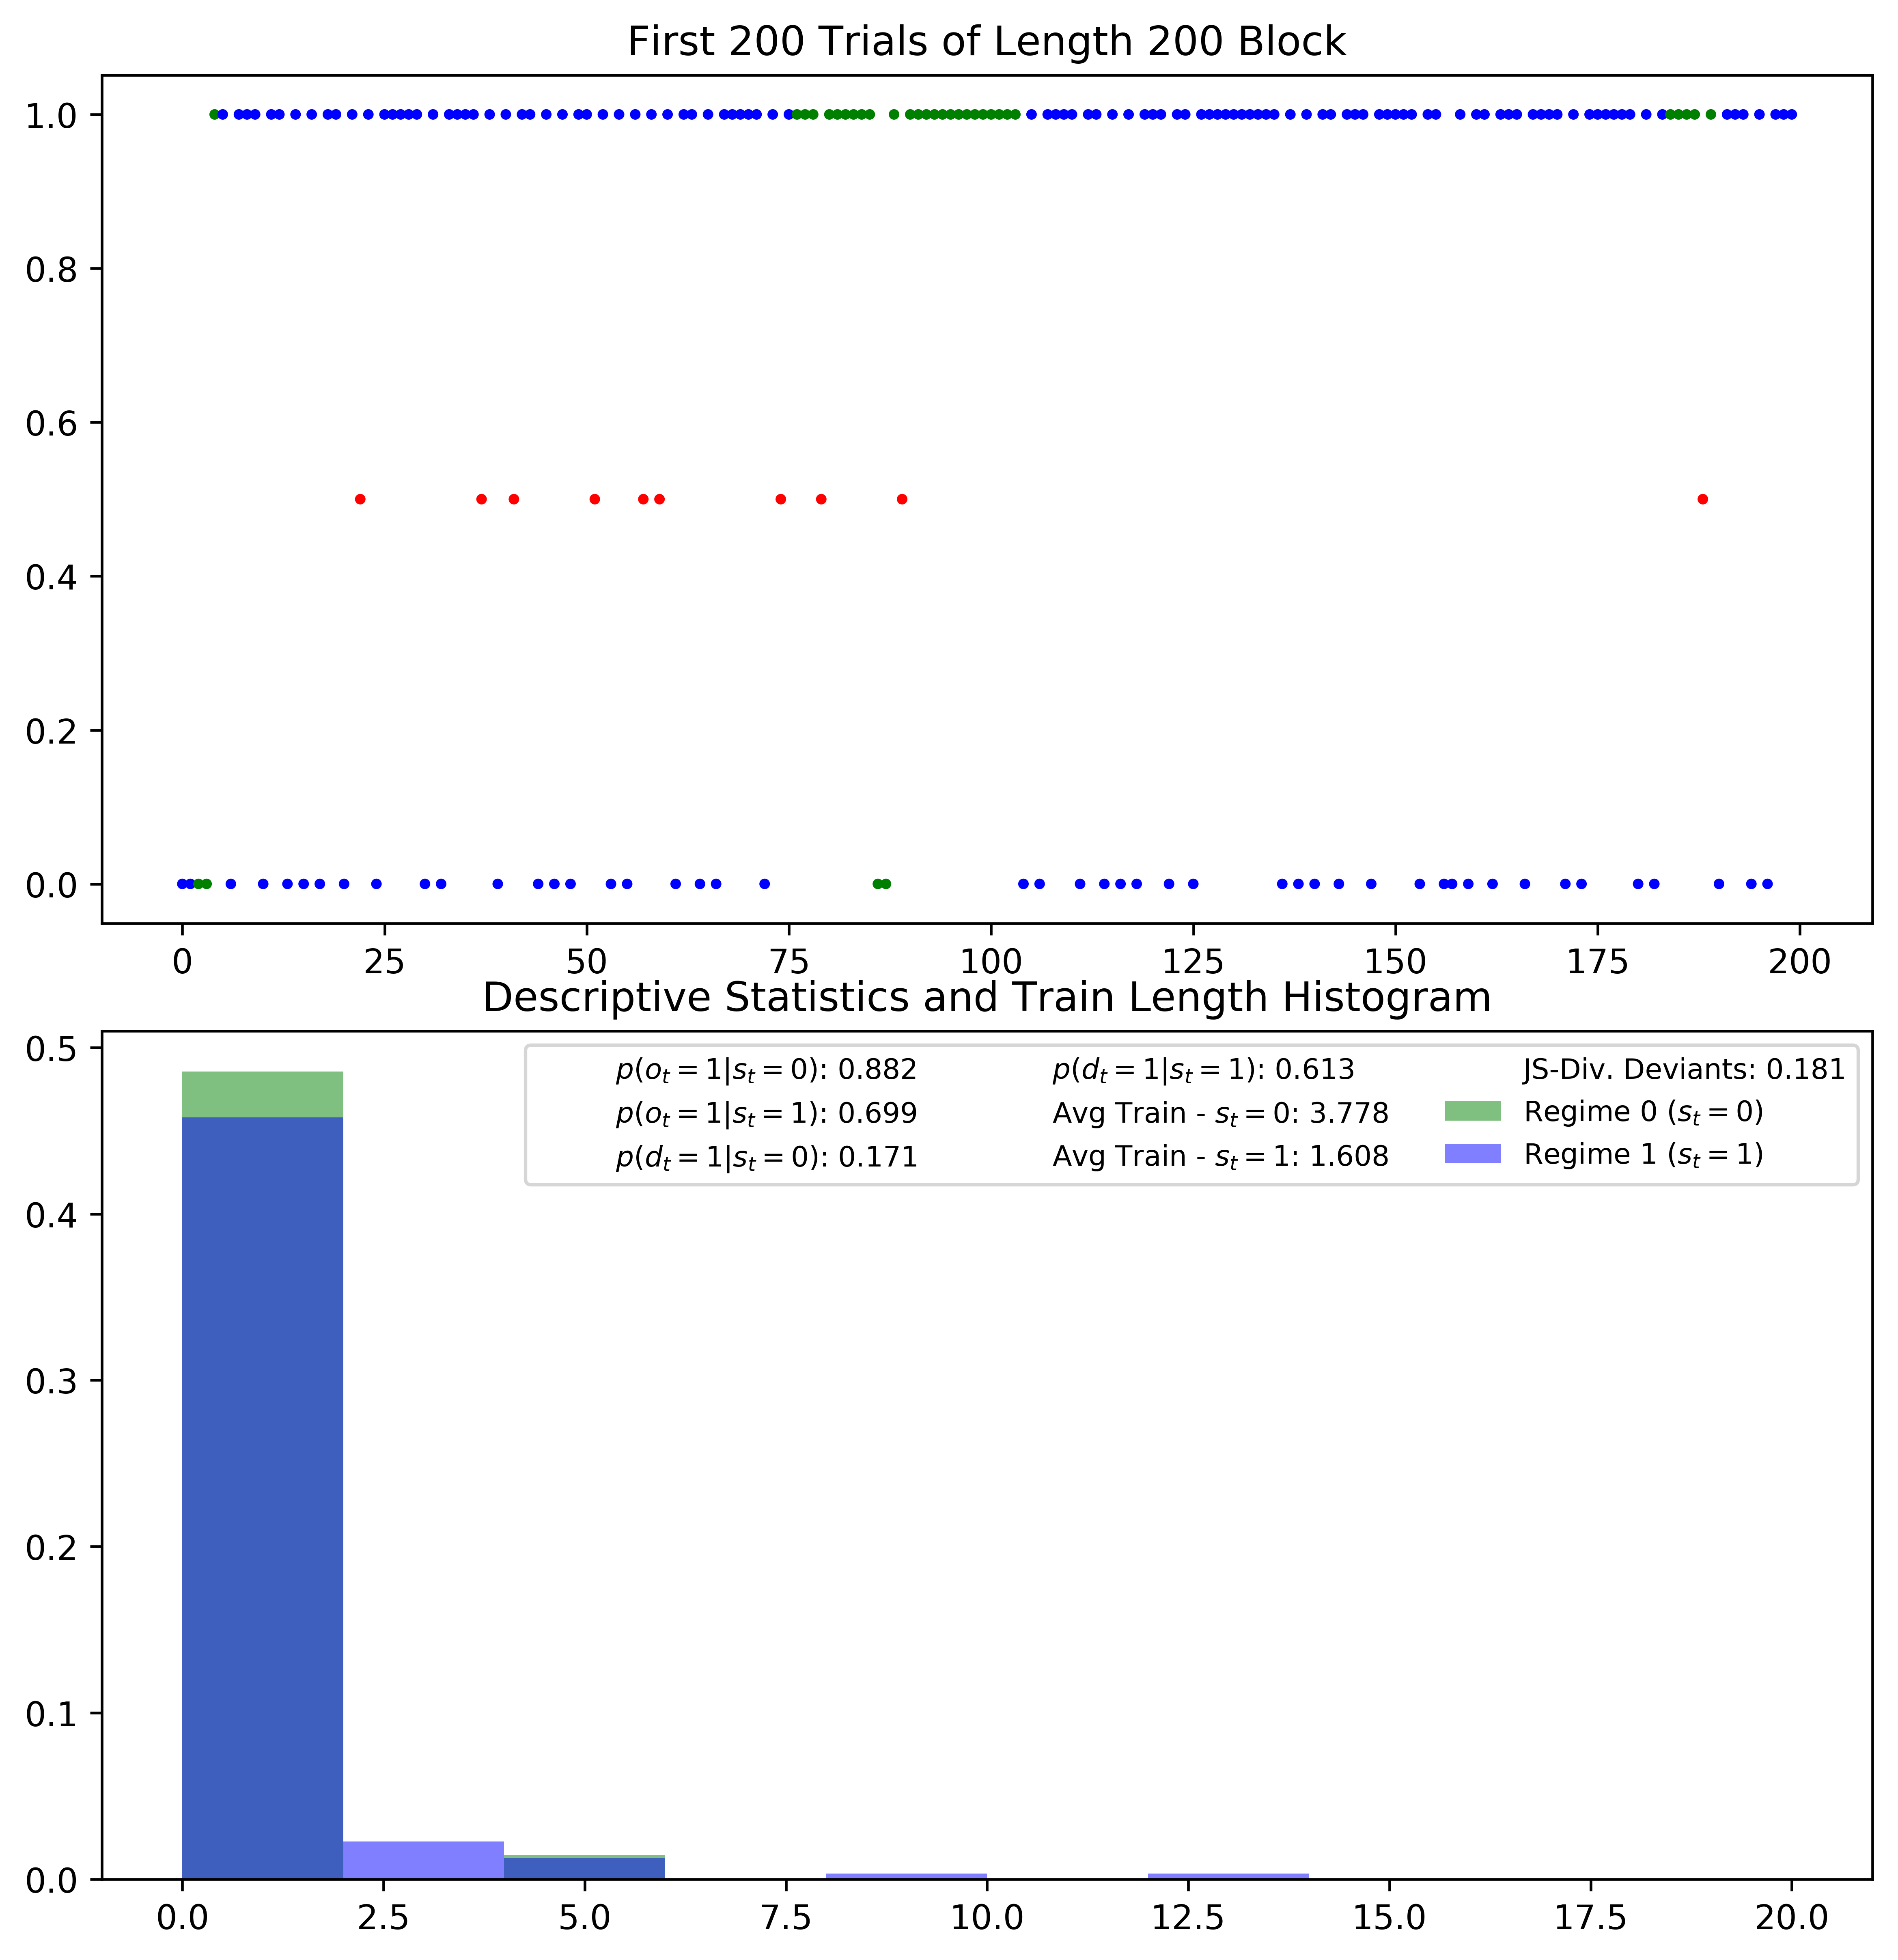

In [5]:
# sequence = gen_temp.sample(seq_length)
# Plot the sampled sequence - when exec from command line
sg.sample_and_save(gen_temp, seq_length, sample_file,
                   matlab_out, plot_seq)

In [ ]:
if plot_seqs:
    sa.main(order=1, verbose=False, plot=True, save=False)

In [ ]:
if plot_seqs:
    sa.main(order=2, verbose=False, plot=True, save=False)

# 2. Modeling of different Sequential Bayesian Learning Agents

In [ ]:
sample_files = [["sub-01_ses-1_run-1", "sub-01_ses-1_run-2",
                 "sub-01_ses-1_run-3", "sub-01_ses-1_run-4",
                 "sub-01_ses-1_run-5"]]

In [ ]:
sample, meta = load_obj("data/" + sample_files[0][0] + ".mat")

seq = sample[:, 2]
hidden = sample[:, 1]

prob_regime_init = meta["prob_regime_init"]
prob_obs_init = meta["prob_obs_init"]
prob_obs_change = meta["prob_obs_change"]
prob_regime_change = meta["prob_regime_change"]

In [ ]:
# General Model Settings
model_types = ["SP", "AP", "TP"]
save_results = True
verbose = True

## 2.1. Conjugate Categorical-Dirichlet Model

In [ ]:
tau = 0.

In [ ]:
# Test agents by calculating posterior after 3 timesteps
# and Surprises for t=1,2,3
for model in model_types:
    sbl_cd.test_agent(seq, hidden, tau, model, verbose)

In [ ]:
for model in model_types:
    sbl_cd.main(seq, hidden, tau, model,
                prob_regime_init, prob_obs_init, prob_obs_change,
                prob_regime_change,
                save_results, title="CD_" + model + "_" + sample_file,
                verbose=True)

In [ ]:
SP_CD = load_obj(results_dir + "CD_" + "SP" + "_" + sample_file + ".pkl")
AP_CD = load_obj(results_dir + "CD_" + "AP" + "_" + sample_file + ".pkl")
TP_CD = load_obj(results_dir + "CD_" + "TP" + "_" + sample_file + ".pkl")

In [ ]:
plot_surprise(SP_CD, AP_CD, TP_CD,
              title=r"Categorical-Dirichlet ($\tau = 0$)",
              save_pic=False)

## 2.2. Hidden Markov Model

In [ ]:
n_states = 2

In [ ]:
# Test agents by calculating posterior after 3 timesteps
# and Surprises for t=1,2,3
for model in model_types:
    sbl_hmm.test_agent(seq, hidden, n_states, model, verbose)

## 3. Model Comparison across Different SBL Agents and Surprise Regressors

In [6]:
sample_files = [["sub-01_ses-1_run-1", "sub-01_ses-1_run-2",
                 "sub-01_ses-1_run-3", "sub-01_ses-1_run-4",
                 "sub-01_ses-1_run-5"]]

electrodes_of_interest = {"FCz": 47, "FC2": 46, "FC4": 45, 
                          "Cz": 48, "C2": 49, "C4": 50,
                          "C6": 51, "CPz": 32, "CP2": 56,
                          "CP4": 55, "CP6": 54}

trial_coding_lookup = {11: "First Regime - Low Intensity",
                       12: "First Regime - High Intensity",
                       21: "Second Regime - Low Intensity",
                       22: "Second Regime - High Intensity",
                       33: "Catch Trial"}

# Select block and electrode for analysis
block_id = 0
elec_id = electrodes_of_interest["FCz"]

In [7]:
# Get Regressors ready!
sample, meta = load_obj("data/" + sample_files[0][block_id] + ".mat")
seq = sample[:, 2]
hidden = sample[:, 1]

In [8]:
PS_SP, BS_SP, CS_SP = sbl_cd.main(seq, hidden, tau=0, model_type="SP")
PS_AP, BS_AP, CS_AP = sbl_cd.main(seq, hidden, tau=0, model_type="AP")
PS_TP, BS_TP, CS_TP = sbl_cd.main(seq, hidden, tau=0, model_type="TP")

regressors = {"PS_SP": PS_SP, "BS_SP": BS_SP, "CS_SP": CS_SP,
              "PS_AP": PS_AP, "BS_AP": BS_AP, "CS_AP": CS_AP,
              "PS_TP": PS_TP, "BS_TP": BS_TP, "CS_TP": CS_TP}

SP: Computing different surprisal measures for 800 timesteps.
SP: Done computing surprisal measures for all 800 timesteps.
AP: Computing different surprisal measures for 800 timesteps.
Can't update posterior with only one observation - need two!
AP: Done computing surprisal measures for all 800 timesteps.
TP: Computing different surprisal measures for 800 timesteps.
Can't update posterior with only one observation - need two!
TP: Done computing surprisal measures for all 800 timesteps.


In [9]:
# Load in EEG Dataset
eeg_files = ["sub-01_sbl"]
eeg_data = sio.loadmat("data/" + eeg_files[0] + ".mat")

In [10]:
# Preprocessor data to get data that we want to explain by the surprise regressors
y_elec = get_electrode_data(eeg_data, block_id, elec_id)

Text(0.5, 1.0, 'Raw FCz Electrode Amplitude at Trial Time')

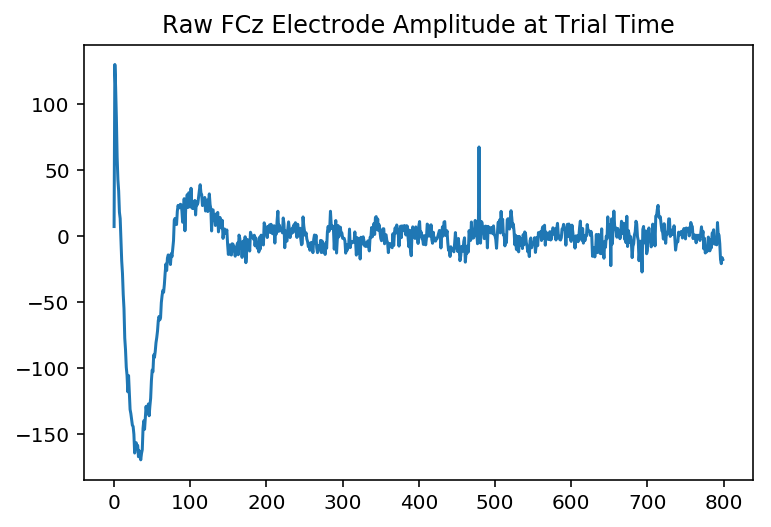

In [11]:
plt.plot(y_elec)
plt.title("Raw FCz Electrode Amplitude at Trial Time")

In [14]:
%time free_energy = run_model_estimation(y_elec, PS_AP, "OLS")

Finished [100%]: Average Loss = 3,949.4


CPU times: user 4.89 s, sys: 305 ms, total: 5.2 s
Wall time: 9.45 s


Text(0.5, 1.0, 'Free Energy/ELBO after ADVI Optimization')

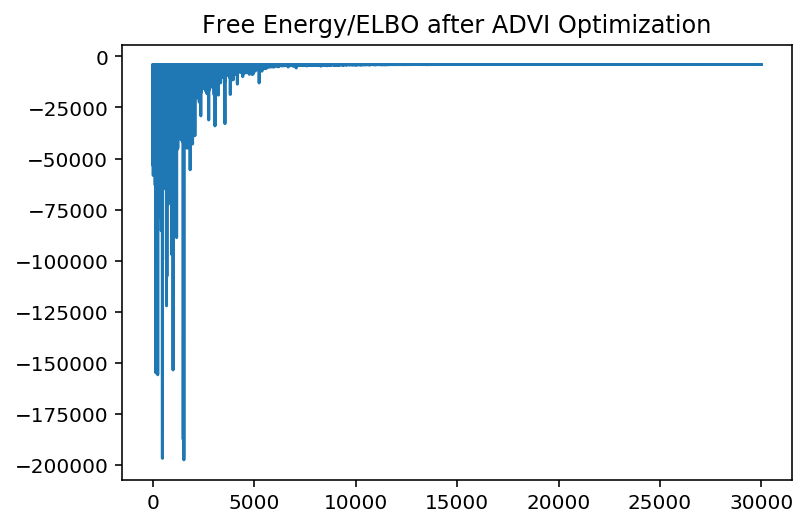

In [15]:
plt.plot(free_energy)
plt.title("Free Energy/ELBO after ADVI Optimization")

In [ ]:
template = "{} Block | {} GLM Model | Free Energy: {} | Time: {}"

log_model_evidences = {"PS_SP": [], "BS_SP": [], "CS_SP": [],
                       "PS_AP": [], "BS_AP": [], "CS_AP": [],
                       "PS_TP": [], "BS_TP": [], "CS_TP": []}

blocks = np.arange(5)
for block_id in blocks:

    sample, meta = load_obj("data/" + sample_files[0][block_id] + ".mat")
    seq, hidden = sample[:, 2], sample[:, 1]
    
    PS_SP, BS_SP, CS_SP = sbl_cd.main(seq, hidden, tau=0, model_type="SP")
    PS_AP, BS_AP, CS_AP = sbl_cd.main(seq, hidden, tau=0, model_type="AP")
    PS_TP, BS_TP, CS_TP = sbl_cd.main(seq, hidden, tau=0, model_type="TP")

    regressors = {"PS_SP": PS_SP, "BS_SP": BS_SP, "CS_SP": CS_SP,
                  "PS_AP": PS_AP, "BS_AP": BS_AP, "CS_AP": CS_AP,
                  "PS_TP": PS_TP, "BS_TP": BS_TP, "CS_TP": CS_TP}
    
    y_elec = get_electrode_data(eeg_data, block_id, elec_id)
    
    for reg_type, surprise_reg in regressors.items():
        start = time.time()
        free_energy = run_model_estimation(y_elec, surprise_reg, "OLS")
        lme_temp = free_energy[-1]
        log_model_evidences[reg_type].append(lme_temp)
        t_time = time.time() - start
        print(template.format(block_id+1, reg_type, lme_temp, t_time))
    

SP: Computing different surprisal measures for 800 timesteps.
SP: Done computing surprisal measures for all 800 timesteps.
AP: Computing different surprisal measures for 800 timesteps.
Can't update posterior with only one observation - need two!
AP: Done computing surprisal measures for all 800 timesteps.
TP: Computing different surprisal measures for 800 timesteps.
Can't update posterior with only one observation - need two!
TP: Done computing surprisal measures for all 800 timesteps.


Finished [100%]: Average Loss = 3,949.3


1 Block | PS_SP GLM Model | Free Energy: -3949.435721432382 | Time: 4.560038089752197


Finished [100%]: Average Loss = 3,950.2


1 Block | BS_SP GLM Model | Free Energy: -3951.63004398734 | Time: 4.195504903793335


Finished [100%]: Average Loss = 3,947.3


1 Block | CS_SP GLM Model | Free Energy: -3947.940132022759 | Time: 4.3879029750823975


Finished [100%]: Average Loss = 3,949.4


1 Block | PS_AP GLM Model | Free Energy: -3947.2961357741015 | Time: 4.272125005722046


Finished [100%]: Average Loss = 3,948.6


1 Block | BS_AP GLM Model | Free Energy: -3948.81033795542 | Time: 4.040913820266724


Finished [100%]: Average Loss = 3,947.2


1 Block | CS_AP GLM Model | Free Energy: -3947.2128178161606 | Time: 3.948028802871704


Finished [100%]: Average Loss = 3,949.4


1 Block | PS_TP GLM Model | Free Energy: -3947.7869070276397 | Time: 4.161343097686768


Finished [100%]: Average Loss = 3,950.1


1 Block | BS_TP GLM Model | Free Energy: -3951.26778714219 | Time: 4.134346008300781


Finished [100%]: Average Loss = 3,947.1


1 Block | CS_TP GLM Model | Free Energy: -3947.266599886299 | Time: 4.621060132980347
SP: Computing different surprisal measures for 800 timesteps.
SP: Done computing surprisal measures for all 800 timesteps.
AP: Computing different surprisal measures for 800 timesteps.
Can't update posterior with only one observation - need two!
AP: Done computing surprisal measures for all 800 timesteps.
TP: Computing different surprisal measures for 800 timesteps.
Can't update posterior with only one observation - need two!
TP: Done computing surprisal measures for all 800 timesteps.


Finished [100%]: Average Loss = 2,842.8


2 Block | PS_SP GLM Model | Free Energy: -2843.248300935702 | Time: 4.140240907669067


Finished [100%]: Average Loss = 2,843.3


2 Block | BS_SP GLM Model | Free Energy: -2843.8945017881883 | Time: 4.032746076583862


Finished [100%]: Average Loss = 2,839.8


2 Block | CS_SP GLM Model | Free Energy: -2839.82519775249 | Time: 4.280858039855957


Finished [100%]: Average Loss = 2,842.8


2 Block | PS_AP GLM Model | Free Energy: -2842.4280999392413 | Time: 3.9902780055999756


Finished [100%]: Average Loss = 2,843


2 Block | BS_AP GLM Model | Free Energy: -2841.3778121915752 | Time: 4.0573060512542725


Finished [100%]: Average Loss = 2,839.4


2 Block | CS_AP GLM Model | Free Energy: -2839.269643830117 | Time: 4.273934841156006


Convergence achieved at 27500
Interrupted at 27,499 [91%]: Average Loss = 2,890.9


2 Block | PS_TP GLM Model | Free Energy: -2845.436376169855 | Time: 4.287773370742798


Finished [100%]: Average Loss = 2,841


2 Block | BS_TP GLM Model | Free Energy: -2840.4850683926456 | Time: 5.786113023757935


Finished [100%]: Average Loss = 2,840.5


2 Block | CS_TP GLM Model | Free Energy: -2840.716362547908 | Time: 4.455476999282837
SP: Computing different surprisal measures for 800 timesteps.
SP: Done computing surprisal measures for all 800 timesteps.
AP: Computing different surprisal measures for 800 timesteps.
Can't update posterior with only one observation - need two!
AP: Done computing surprisal measures for all 800 timesteps.
TP: Computing different surprisal measures for 800 timesteps.
Can't update posterior with only one observation - need two!
TP: Done computing surprisal measures for all 800 timesteps.


Finished [100%]: Average Loss = 3,334.4


3 Block | PS_SP GLM Model | Free Energy: -3335.0359655025145 | Time: 4.700569152832031


Finished [100%]: Average Loss = 3,335.8


3 Block | BS_SP GLM Model | Free Energy: -3337.3900923343463 | Time: 4.398234844207764


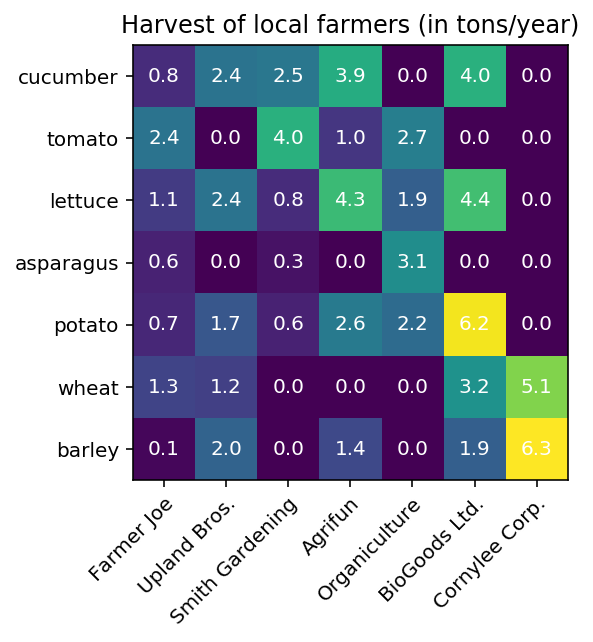

In [16]:
vegetables = ["cucumber", "tomato", "lettuce", "asparagus",
              "potato", "wheat", "barley"]
farmers = ["Farmer Joe", "Upland Bros.", "Smith Gardening",
           "Agrifun", "Organiculture", "BioGoods Ltd.", "Cornylee Corp."]

harvest = np.array([[0.8, 2.4, 2.5, 3.9, 0.0, 4.0, 0.0],
                    [2.4, 0.0, 4.0, 1.0, 2.7, 0.0, 0.0],
                    [1.1, 2.4, 0.8, 4.3, 1.9, 4.4, 0.0],
                    [0.6, 0.0, 0.3, 0.0, 3.1, 0.0, 0.0],
                    [0.7, 1.7, 0.6, 2.6, 2.2, 6.2, 0.0],
                    [1.3, 1.2, 0.0, 0.0, 0.0, 3.2, 5.1],
                    [0.1, 2.0, 0.0, 1.4, 0.0, 1.9, 6.3]])


fig, ax = plt.subplots()
im = ax.imshow(harvest)

# We want to show all ticks...
ax.set_xticks(np.arange(len(farmers)))
ax.set_yticks(np.arange(len(vegetables)))
# ... and label them with the respective list entries
ax.set_xticklabels(farmers)
ax.set_yticklabels(vegetables)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(vegetables)):
    for j in range(len(farmers)):
        text = ax.text(j, i, harvest[i, j],
                       ha="center", va="center", color="w")

ax.set_title("Harvest of local farmers (in tons/year)")
plt.show()